# Football Passmaps
This notebook generates Passmaps for Football matches using WhoScored.

## Import libraries

In [1]:
import json
import re
import pandas as pd

## Extract json from html

In [118]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r', encoding="utf8")
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

## Extract data from dict

In [119]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

## Enter html file name for desired match

In [ ]:
match_html_path = 'Manchester City 1-0 Inter - Champions League 2022_2023 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

players_df.head()

## Create passes dataframe

In [122]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

In [ ]:
passes_df = get_passes_df(events_dict)
passes_df.head()

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.559923e+09,49.9,49.8,38.6,42.6,75,299344.0,87449.0,Pass,Successful
3,2.559923e+09,38.6,42.6,26.1,57.5,75,87449.0,54968.0,Pass,Successful
4,2.559923e+09,25.7,57.5,6.4,48.2,75,54968.0,260843.0,Pass,Successful
5,2.559923e+09,7.8,45.1,12.3,24.0,75,260843.0,23220.0,Pass,Successful
6,2.559923e+09,12.6,24.3,9.3,46.5,75,23220.0,260843.0,Pass,Successful


## Create pass direction dataframe

In [124]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [125]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)

In [126]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [128]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 20
    MAX_MARKER_SIZE = 2000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    iron = '#48494B'
    city = '#98c5e9'
    united = '#db0006'
    white = '#FFFFFF'
    inter = '#131da3'
    
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba(white))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color=iron, line_color='#000000')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='o',
                               color=inter, edgecolors=white, linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#FFFFFF', va='center',
                       ha='center', size=10, ax=ax)

    return pitch

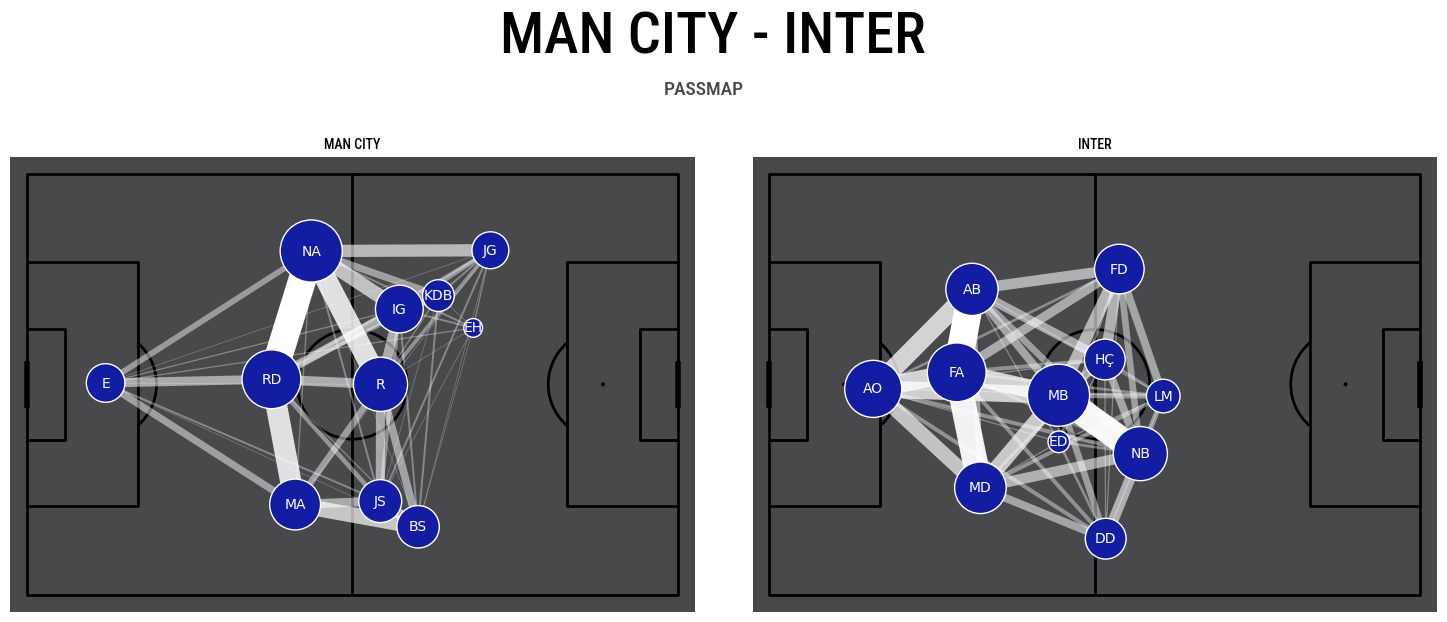

In [129]:
# create plot
fig, axes = plt.subplots(1,2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#FFFFFF")

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id].upper(), color="#000000", fontsize=14, fontproperties=font_bold.prop)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=False)
axes[1].set_title(teams_dict[away_team_id].upper(), color="#000000", fontsize=14, fontproperties=font_bold.prop)

plt.suptitle( f"{teams_dict[home_team_id].upper()} - {teams_dict[away_team_id].upper()}", color="#000000", fontsize=42, fontproperties=font_bold.prop)
subtitle = "PASSMAP"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14, fontproperties=font_bold.prop)
plt.savefig('output.png', bbox_inches='tight')
plt.show()


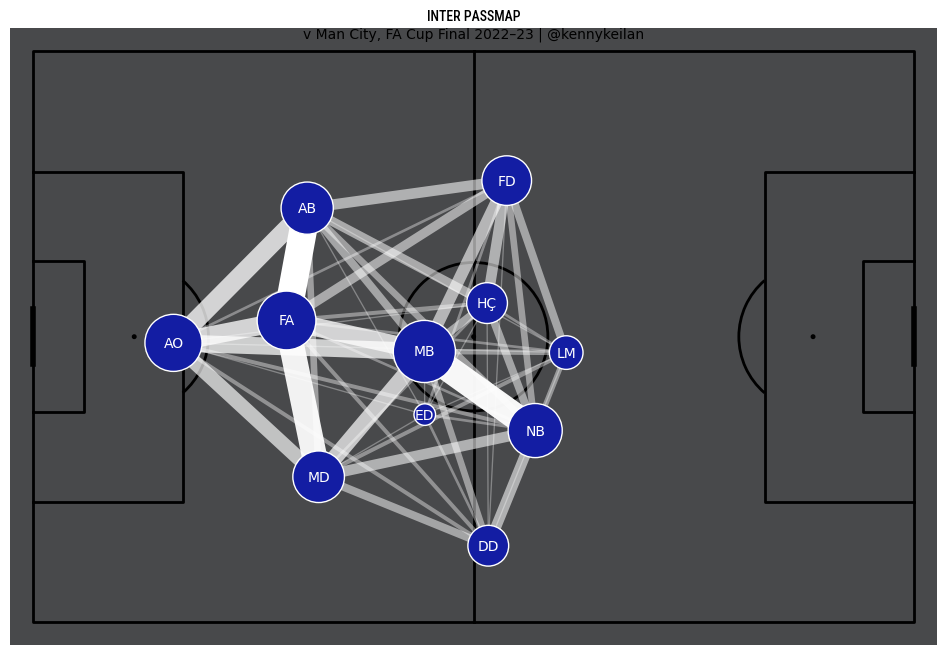

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
fig.set_facecolor("#FFFFFF")

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))



pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df)
ax.set_title(f"{teams_dict[away_team_id].upper()} PASSMAP", color="#000000", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[home_team_id]}, FA Cup Final 2022–23 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#000000", fontsize=10)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

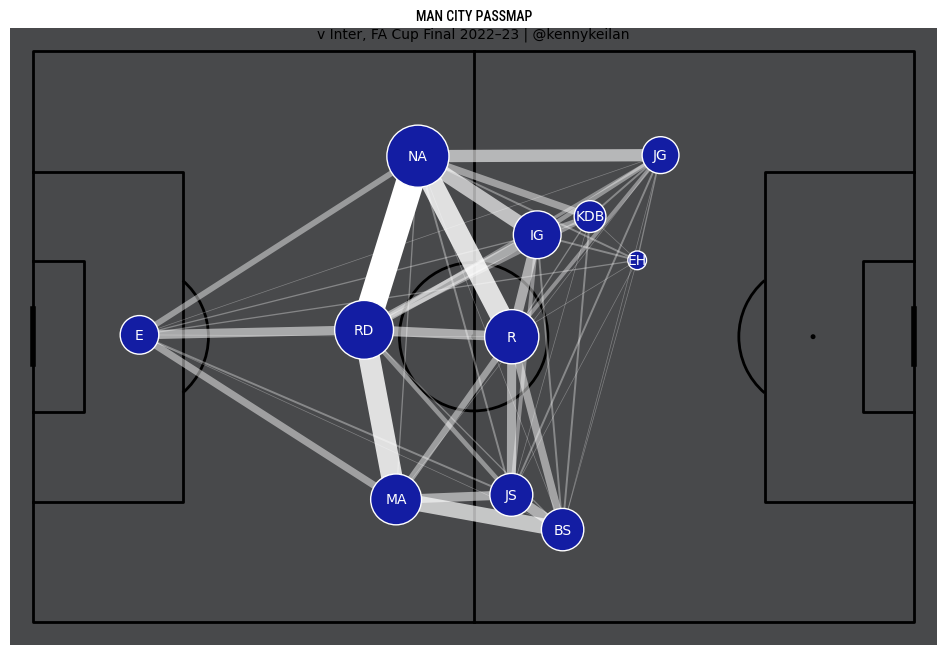

In [131]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
fig.set_facecolor("#FFFFFF")

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))



pass_network_visualization(ax, home_passes_between_df, home_average_locs_and_count_df)
ax.set_title(f"{teams_dict[home_team_id].upper()} PASSMAP", color="#000000", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[away_team_id]}, FA Cup Final 2022–23 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#000000", fontsize=10)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

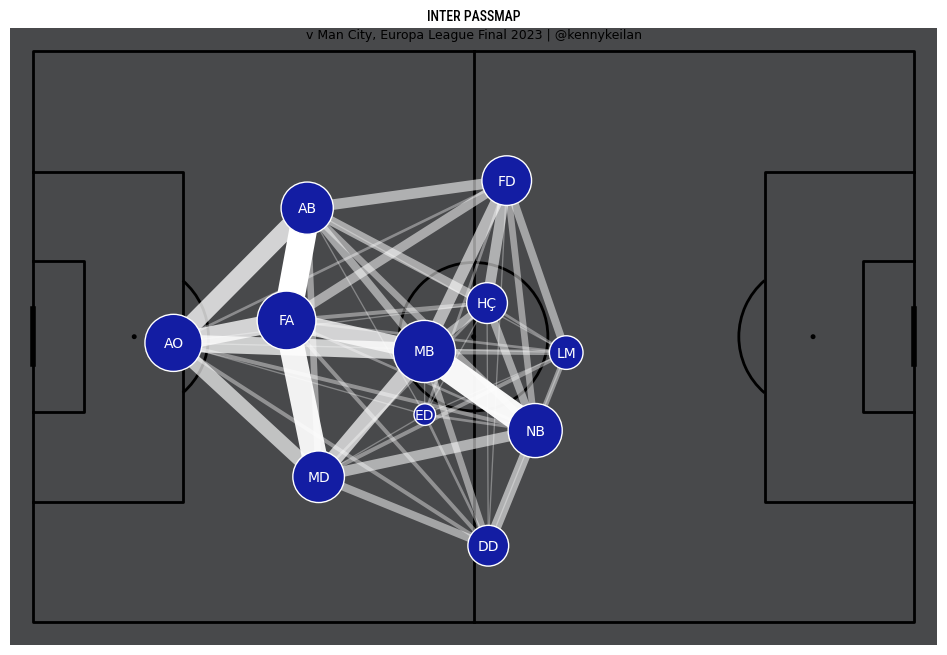

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
fig.set_facecolor("#FFFFFF")

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))


pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df)
ax.set_title(f"{teams_dict[away_team_id].upper()} PASSMAP", color="#000000", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[home_team_id]}, Europa League Final 2023 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#000000", fontsize=9)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

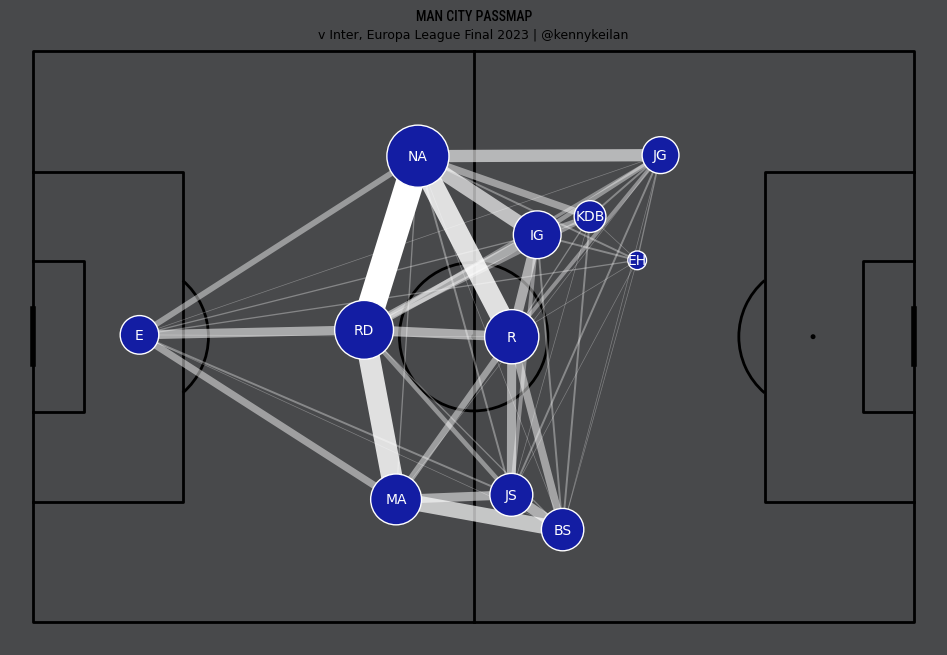

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
iron = '#48494B'
fig.set_facecolor(iron)

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))


pass_network_visualization(ax, home_passes_between_df, home_average_locs_and_count_df)
ax.set_title(f"{teams_dict[home_team_id].upper()} PASSMAP", color="#000000", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[away_team_id]}, Europa League Final 2023 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#000000", fontsize=9)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

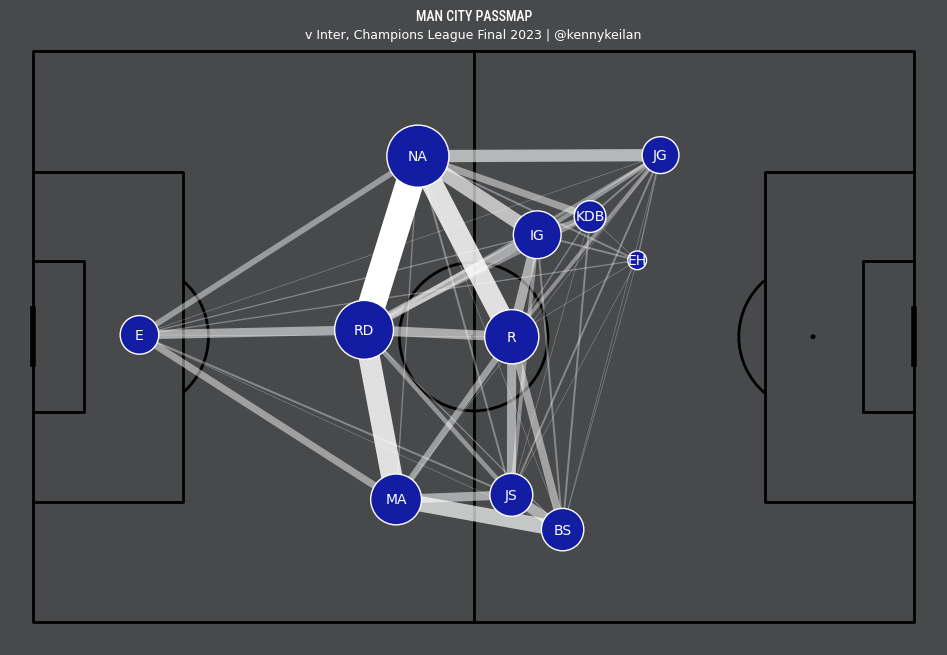

In [134]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
iron = '#48494B'
fig.set_facecolor(iron)

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))


pass_network_visualization(ax, home_passes_between_df, home_average_locs_and_count_df)
ax.set_title(f"{teams_dict[home_team_id].upper()} PASSMAP", color="white", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[away_team_id]}, Champions League Final 2023 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#FFFFFF", fontsize=9)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

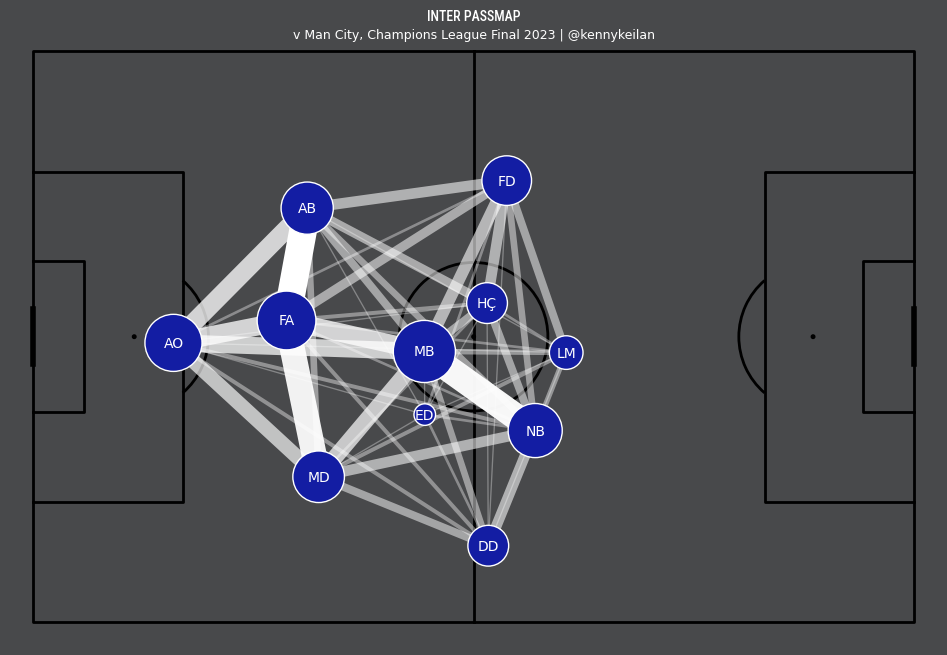

In [135]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
iron = '#48494B'
fig.set_facecolor(iron)

# plot variables
main_color = '#474746'
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "RobotoCondensed-Medium.ttf?raw=true"))


pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df)
ax.set_title(f"{teams_dict[away_team_id].upper()} PASSMAP", color="#FFFFFF", fontsize=50, fontproperties=font_bold.prop)
subtitle = f"v {teams_dict[home_team_id]}, Champions League Final 2023 | @kennykeilan"
plt.text(50, 103, subtitle, horizontalalignment='center', verticalalignment='center', color="#FFFFFF", fontsize=9)
plt.savefig('output.png', bbox_inches='tight')
plt.show()